In [ ]:

!apt-get install openjdk-11-jdk -y

!pip install pyspark matplotlib seaborn --quiet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 30 not upgraded.
Need to get 5,366 kB of archives.
After this operation, 15.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [ ]:
!pip install pyspark[pandas]

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from pyspark.sql import SparkSession
import numpy as np



In [ ]:
spark = SparkSession.builder \
    .appName("Crypto Coin Analysis") \
    .master("local[*]") \
    .getOrCreate()

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


spark.sparkContext.setLogLevel("ERROR")


In [ ]:

coin_list = [
    "BTC", "ETH", "LTC", "NEO", "BNB", "XRP", "LINK", "EOS", "TRX",
    "ETC", "XLM", "ZEC", "ADA", "QTUM", "DASH", "XMR", "BTT"
]


with open("binance_multicoin_dataset.csv", 'wb') as bds:
    bds.write(b"unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount\n")


    for coin in coin_list:
        print(f"Downloading Binance data for {coin}...")
        url = f"http://www.cryptodatadownload.com/cdd/Binance_{coin}USDT_minute.csv"
        r = requests.get(url)
        content = b"\n".join(r.content.splitlines()[1:])
        bds.write(content + b"\n")


In [ ]:

# Reinstall compatible version of PySpark if needed
!pip install --quiet pyspark==3.5.0

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"  # Prevent Spark timezone issues

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("BinanceAnalysis").getOrCreate()

# Load the dataset with corrected path
df = spark.read.csv("/content/binance_multicoin_dataset.csv", header=True, inferSchema=True)

# Filter rows with non-null symbol
df = df.filter(col("symbol").isNotNull())

# Show sample data
df.show(5)








+-------------+-------------------+--------+--------------+--------------+--------------+--------------+-----------+----------------+----------+
|         unix|               date|  symbol|          open|          high|           low|         close| Volume BTC|     Volume USDT|tradecount|
+-------------+-------------------+--------+--------------+--------------+--------------+--------------+-----------+----------------+----------+
|         unix|               date|  symbol|          open|          high|           low|         close| Volume BTC|     Volume USDT|tradecount|
|1658911380000|2022-07-27 08:43:00|BTC/USDT|21374.96000000|21383.02000000|21371.20000000|21379.57000000|19.00999000| 406380.47461670|       947|
|1658911320000|2022-07-27 08:42:00|BTC/USDT|21365.39000000|21376.76000000|21360.00000000|21373.64000000|58.41095000|1248064.18465660|      2452|
|1658911260000|2022-07-27 08:41:00|BTC/USDT|21368.87000000|21383.24000000|21361.66000000|21366.17000000|93.96567000|2008268.752573

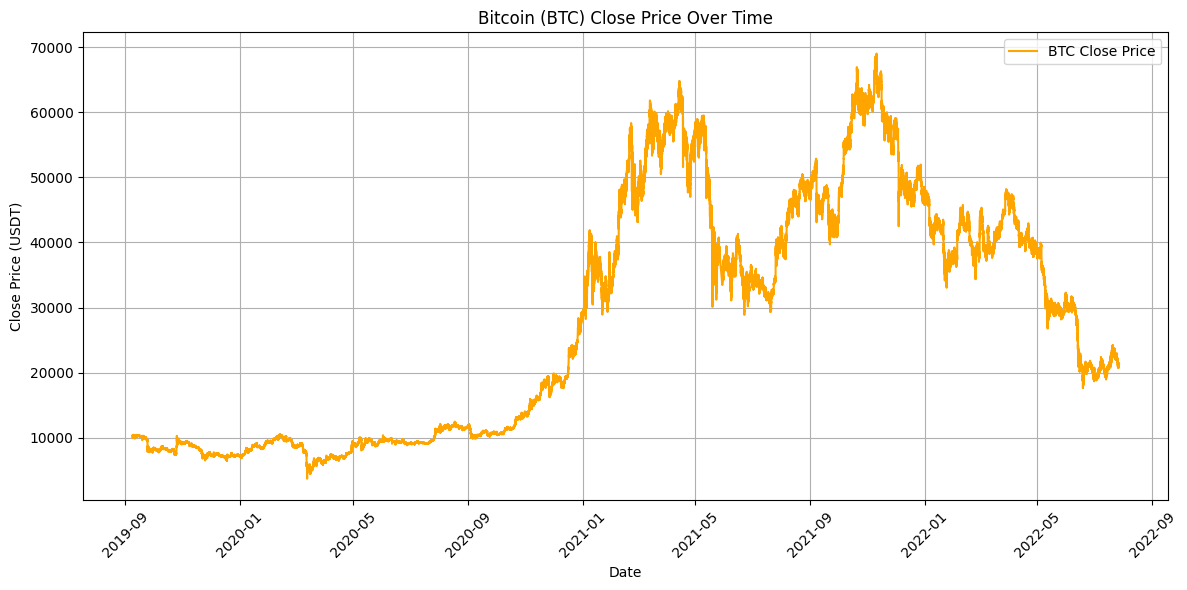

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd


btc_df = df.filter(col("symbol") == "BTC/USDT") \
           .withColumn("close", col("close").cast("double")) \
           .orderBy(col("date"))


btc_pd = btc_df.select("date", "close").toPandas()


btc_pd["date"] = pd.to_datetime(btc_pd["date"], errors="coerce")


plt.figure(figsize=(12, 6))
plt.plot(btc_pd["date"], btc_pd["close"], label="BTC Close Price", color='orange')
plt.xlabel("Date")
plt.ylabel("Close Price (USDT)")
plt.title("Bitcoin (BTC) Close Price Over Time")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



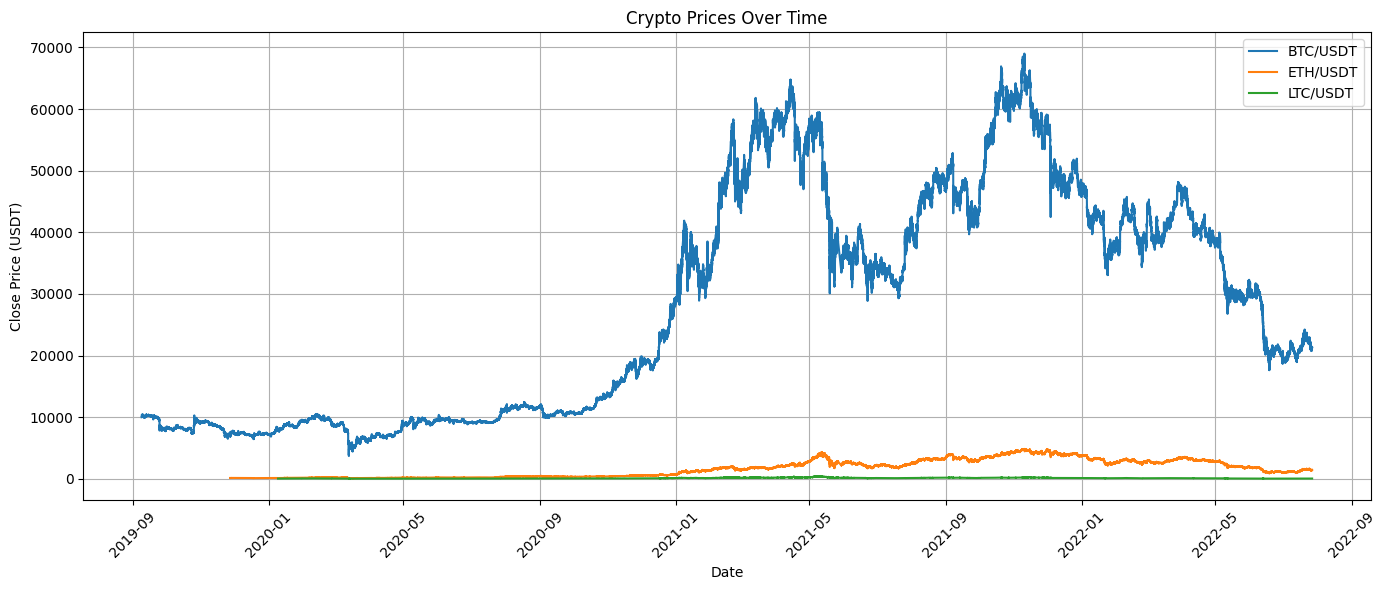

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd


top_df = df.filter(col("symbol").isin(["BTC/USDT", "ETH/USDT", "LTC/USDT"])) \
           .withColumn("close", col("close").cast("double")) \
           .orderBy("date")


top_pd = top_df.select("date", "symbol", "close").toPandas()


top_pd["date"] = pd.to_datetime(top_pd["date"], errors="coerce")


plt.figure(figsize=(14, 6))
for symbol in ["BTC/USDT", "ETH/USDT", "LTC/USDT"]:
    temp = top_pd[top_pd["symbol"] == symbol]
    plt.plot(temp["date"], temp["close"], label=symbol)

plt.title("Crypto Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (USDT)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



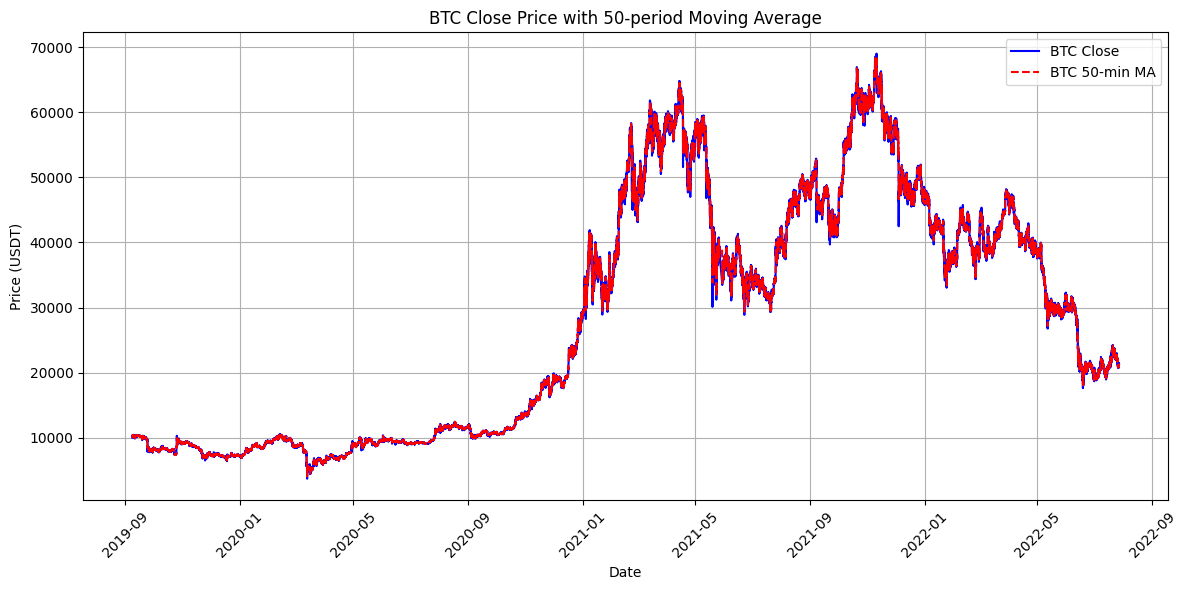

In [ ]:

btc_pd["ma50"] = btc_pd["close"].rolling(window=50).mean()


plt.figure(figsize=(12, 6))
plt.plot(btc_pd["date"], btc_pd["close"], label="BTC Close", color='blue')
plt.plot(btc_pd["date"], btc_pd["ma50"], label="BTC 50-min MA", linestyle="--", color='red')
plt.title("BTC Close Price with 50-period Moving Average")
plt.xlabel("Date")
plt.ylabel("Price (USDT)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

btc_df = df.filter(col("symbol") == "BTC/USDT") \
           .withColumn("close", col("close").cast("double")) \
           .withColumn("Volume_USDT", col("Volume USDT").cast("double")) \
           .orderBy(col("date"))

btc_pd = btc_df.select("date", "close", "Volume_USDT").toPandas()
btc_pd.columns = btc_pd.columns.str.strip()






<ipython-input-3-b826d9328f56>:5: DtypeWarning: Columns (0,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("binance_multicoin_dataset.csv")


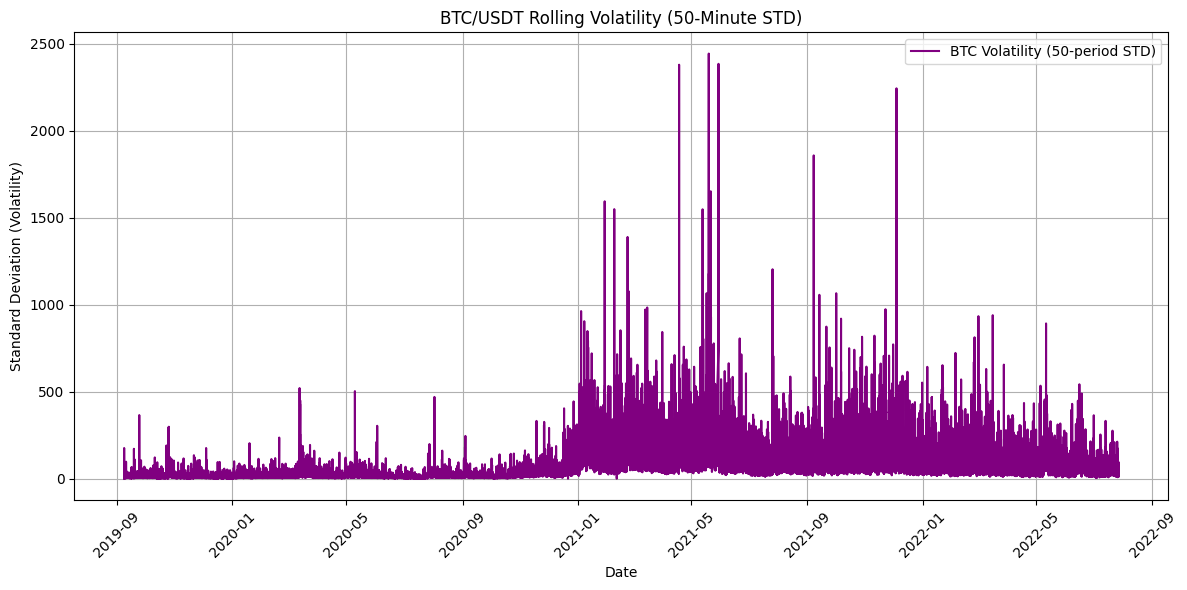

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("binance_multicoin_dataset.csv")


btc_pd = df[df["symbol"] == "BTC/USDT"].copy()
btc_pd["date"] = pd.to_datetime(btc_pd["date"])
btc_pd["close"] = pd.to_numeric(btc_pd["close"], errors="coerce")
btc_pd = btc_pd.sort_values("date")

btc_pd["volatility_50"] = btc_pd["close"].rolling(window=50).std()


plt.figure(figsize=(12, 6))
plt.plot(btc_pd["date"], btc_pd["volatility_50"], label="BTC Volatility (50-period STD)", color='purple')
plt.title("BTC/USDT Rolling Volatility (50-Minute STD)")
plt.xlabel("Date")
plt.ylabel("Standard Deviation (Volatility)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()







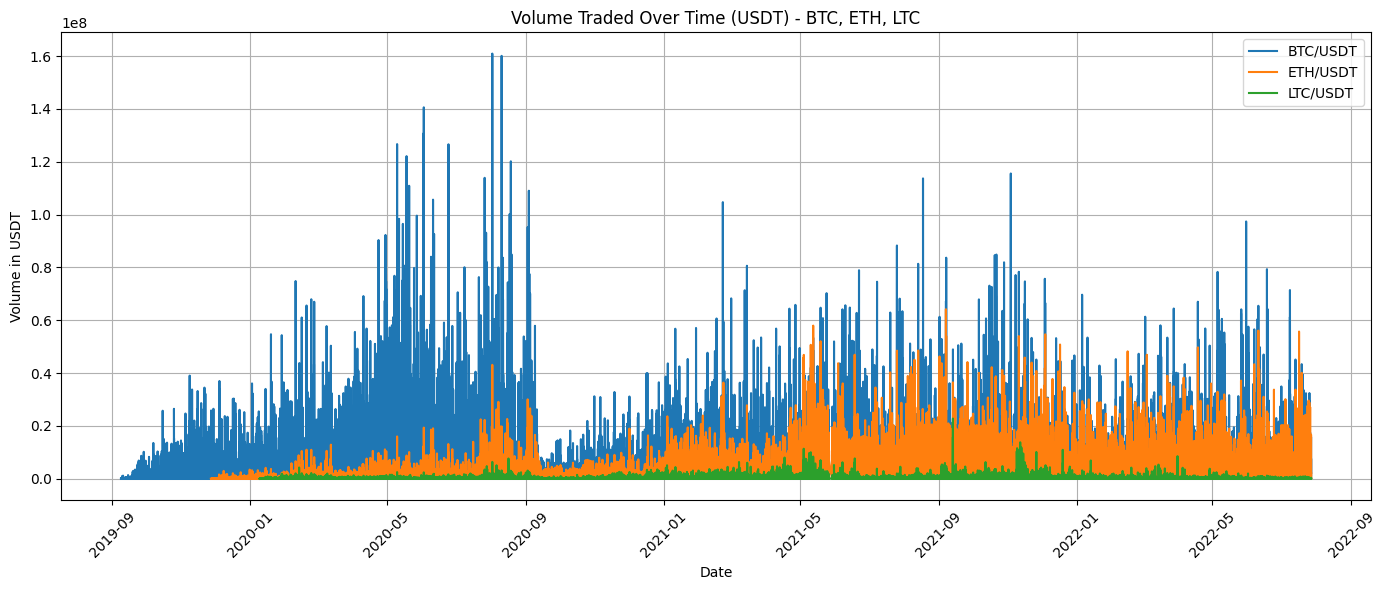

In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder.appName("MultiCoinVolumeViz").getOrCreate()


df = spark.read.csv("binance_multicoin_dataset.csv", header=True, inferSchema=True)


top_df = df.filter(col("symbol").isin(["BTC/USDT", "ETH/USDT", "LTC/USDT"])) \
           .withColumn("Volume_USDT", col("`Volume USDT`").cast("double")) \
           .withColumn("date", col("date")) \
           .select("date", "symbol", "Volume_USDT")


top_pd = top_df.toPandas()
top_pd["date"] = pd.to_datetime(top_pd["date"])
top_pd = top_pd.sort_values("date")


plt.figure(figsize=(14, 6))
for symbol in ["BTC/USDT", "ETH/USDT", "LTC/USDT"]:
    coin_data = top_pd[top_pd["symbol"] == symbol]
    plt.plot(coin_data["date"], coin_data["Volume_USDT"], label=symbol)

plt.title("Volume Traded Over Time (USDT) - BTC, ETH, LTC")
plt.xlabel("Date")
plt.ylabel("Volume in USDT")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




+-------------+-------------------+--------+--------------+--------------+--------------+--------------+-----------+----------------+----------+
|         unix|               date|  symbol|          open|          high|           low|         close| Volume BTC|     Volume USDT|tradecount|
+-------------+-------------------+--------+--------------+--------------+--------------+--------------+-----------+----------------+----------+
|         unix|               date|  symbol|          open|          high|           low|         close| Volume BTC|     Volume USDT|tradecount|
|1658911380000|2022-07-27 08:43:00|BTC/USDT|21374.96000000|21383.02000000|21371.20000000|21379.57000000|19.00999000| 406380.47461670|       947|
|1658911320000|2022-07-27 08:42:00|BTC/USDT|21365.39000000|21376.76000000|21360.00000000|21373.64000000|58.41095000|1248064.18465660|      2452|
|1658911260000|2022-07-27 08:41:00|BTC/USDT|21368.87000000|21383.24000000|21361.66000000|21366.17000000|93.96567000|2008268.752573

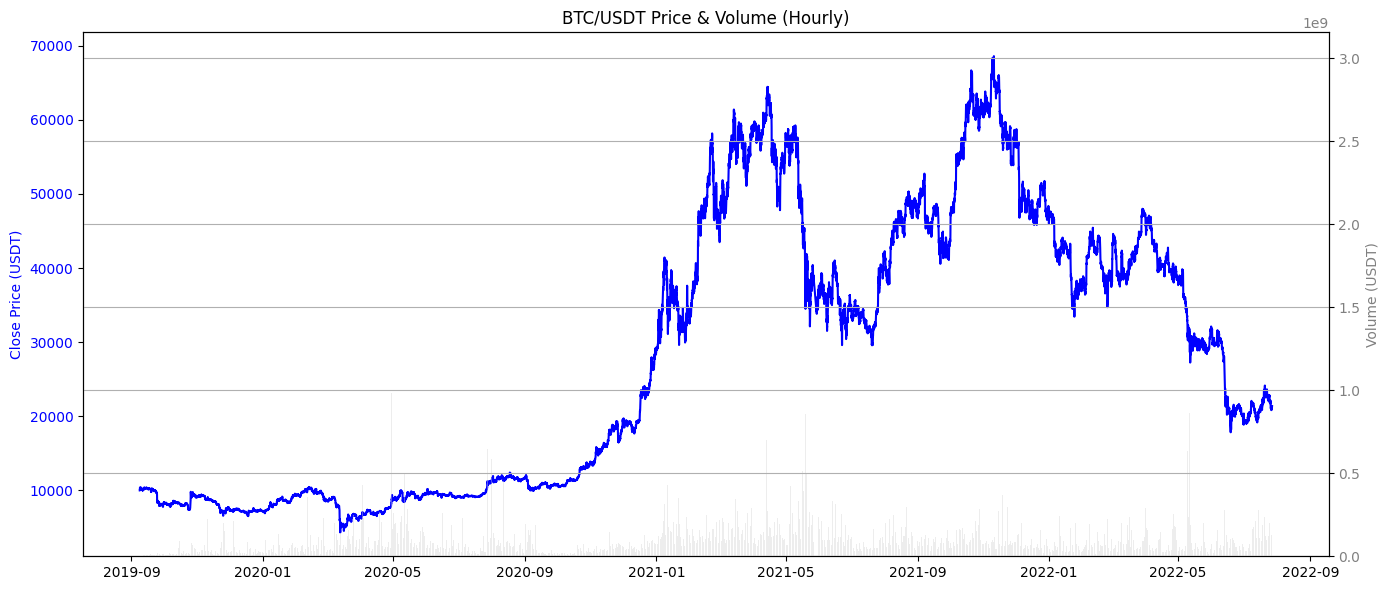

In [ ]:
# Step 1: Reinstall compatible version of PySpark if needed
!pip install --quiet pyspark==3.5.0

# Step 2: Set environment variables for Java and PySpark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"  # Prevent Spark timezone issues

# Step 3: Initialize Spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.master("local[*]").appName("BinanceAnalysis").getOrCreate()

# Step 4: Load the dataset with corrected path
file_path = "/content/binance_multicoin_dataset.csv"  # Ensure this path is correct
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 5: Filter rows with non-null 'symbol'
df = df.filter(col("symbol").isNotNull())

# Step 6: Show sample data to verify load
df.show(5)

# Step 7: Filter BTC/USDT data and cast numeric columns to the correct types
btc_df = df.filter(col("symbol") == "BTC/USDT") \
           .withColumn("close", col("close").cast("double")) \
           .withColumn("Volume_USDT", col("Volume USDT").cast("double")) \
           .orderBy(col("date"))

# Step 8: Convert to Pandas DataFrame for further processing
btc_pd = btc_df.select("date", "close", "Volume_USDT").toPandas()
btc_pd.columns = btc_pd.columns.str.strip()  # Strip any extra spaces from column names

# Step 9: Convert the date column to datetime in Pandas
import pandas as pd
btc_pd["date"] = pd.to_datetime(btc_pd["date"], errors="coerce")

# Step 10: Set datetime index in Pandas DataFrame
btc_pd = btc_pd.set_index("date")

# Step 11: Resample to hourly data
btc_hourly = btc_pd.resample("1h").agg({
    "close": "mean",
    "Volume_USDT": "sum"
}).dropna().reset_index()

# Step 12: Plot using Matplotlib
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 6))

# Line plot for BTC close price
ax1.plot(btc_hourly["date"], btc_hourly["close"], label="BTC Close Price", color="blue")
ax1.set_ylabel("Close Price (USDT)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Twin axis for volume
ax2 = ax1.twinx()
ax2.bar(btc_hourly["date"], btc_hourly["Volume_USDT"], label="Volume (USDT)",
        color="lightgray", alpha=0.4, width=0.03)
ax2.set_ylabel("Volume (USDT)", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

# Formatting
plt.title("BTC/USDT Price & Volume (Hourly)")
plt.xticks(rotation=45)
plt.grid(True)
fig.tight_layout()
plt.show()











✅ Evaluation:
RMSE: 596.53
MAE: 396.26
R²: 0.9989


<ipython-input-2-73871c58e6b4>:105: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


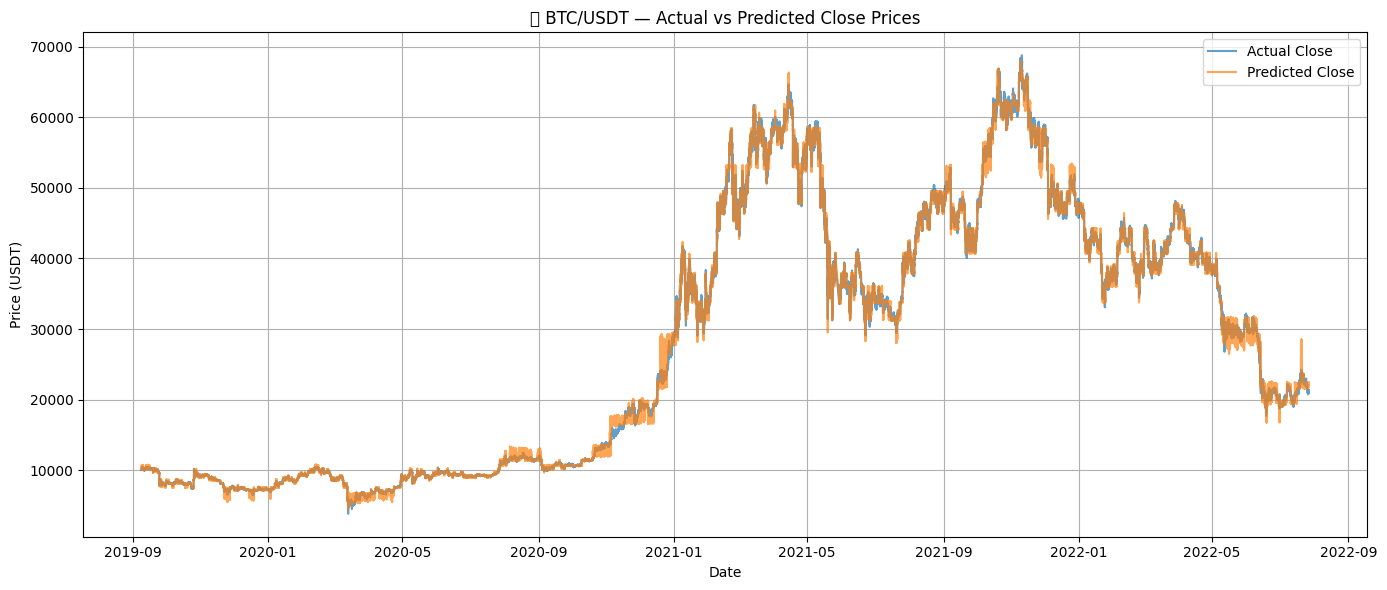


📊 Feature Importances:
open           : 0.0012
high           : 0.0044
low            : 0.1251
Volume USDT    : 0.0001
5_min_ma       : 0.8265
30_min_ma      : 0.0000
rolling_max    : 0.0006
rolling_min    : 0.0006
volatility     : 0.0001
close_t-1      : 0.0000
close_t-2      : 0.0407
close_t-3      : 0.0001
return_t-1     : 0.0000
return_t-2     : 0.0000
hour           : 0.0001
day_of_week    : 0.0003


In [ ]:

!pip install -q pyspark


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, avg, lag, stddev, hour, dayofweek, max as max_, min as min_
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt


spark = SparkSession.builder.appName("BTC_Price_Predictor").getOrCreate()


df = spark.read.csv("binance_multicoin_dataset.csv", header=True, inferSchema=True)
df = df.withColumn("date", unix_timestamp("date", "yyyy-MM-dd HH:mm:ss").cast("timestamp"))

# Type Casting
numeric_cols = ["open", "high", "low", "close", "Volume USDT"]
for c in numeric_cols:
    df = df.withColumn(c, col(c).cast("double"))

# Filter BTC/USDT only
df = df.filter(df["symbol"] == "BTC/USDT").dropna()

# Create windows
symbol_window = Window.partitionBy("symbol").orderBy("date")
rolling_window_5 = symbol_window.rowsBetween(-4, 0)
rolling_window_30 = symbol_window.rowsBetween(-29, 0)


df = df.withColumn("5_min_ma", avg("close").over(rolling_window_5))
df = df.withColumn("30_min_ma", avg("close").over(rolling_window_30))
df = df.withColumn("rolling_max", max_("close").over(rolling_window_30))
df = df.withColumn("rolling_min", min_("close").over(rolling_window_30))
df = df.withColumn("volatility", stddev("close").over(rolling_window_5))

# Lag Features
for i in range(1, 4):
    df = df.withColumn(f"close_t-{i}", lag("close", i).over(symbol_window))

# Return Features
df = df.withColumn("return_t-1", (col("close_t-1") - col("close_t-2")) / col("close_t-2"))
df = df.withColumn("return_t-2", (col("close_t-2") - col("close_t-3")) / col("close_t-3"))

# Time-based Features
df = df.withColumn("hour", hour("date"))
df = df.withColumn("day_of_week", dayofweek("date"))

# Drop nulls
df = df.dropna()

# Feature Columns
feature_cols = [
    "open", "high", "low", "Volume USDT", "5_min_ma", "30_min_ma",
    "rolling_max", "rolling_min", "volatility",
    "close_t-1", "close_t-2", "close_t-3",
    "return_t-1", "return_t-2",
    "hour", "day_of_week"
]

# Assemble & Scale
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
scaler = StandardScaler(inputCol="raw_features", outputCol="features")

#  GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="close", maxDepth=6, maxIter=75, stepSize=0.1)

# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, gbt])

# Split Data
train, test = df.randomSplit([0.8, 0.2], seed=42)
train = train.cache()
test = test.cache()

# Train
model = pipeline.fit(train)

# Predict
predictions = model.transform(test)

# Evaluate
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
mae = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="mae").evaluate(predictions)
r2 = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2").evaluate(predictions)
print(f"\n✅ Evaluation:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.4f}")

# Convert to Pandas for Plotting
predictions_pd = predictions.select("date", "close", "prediction").orderBy("date").toPandas()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(predictions_pd["date"], predictions_pd["close"], label="Actual Close", alpha=0.7)
plt.plot(predictions_pd["date"], predictions_pd["prediction"], label="Predicted Close", alpha=0.7)
plt.title("📈 BTC/USDT — Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Price (USDT)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importances
gbt_model = model.stages[-1]
importances = gbt_model.featureImportances
print("\n📊 Feature Importances:")
for f, imp in zip(feature_cols, importances.toArray()):
    print(f"{f:15s}: {imp:.4f}")

# Stop Spark
spark.stop()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
33974/33974 ━━━━━━━━━━━━━━━━━━━━ 1801s 53ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 2/5
33974/33974 ━━━━━━━━━━━━━━━━━━━━ 1776s 52ms/step - loss: 6.6628e-04 - val_loss: 9.2190e-05
Epoch 3/5
33974/33974 ━━━━━━━━━━━━━━━━━━━━ 1855s 53ms/step - loss: 6.5073e-04 - val_loss: 2.9770e-05
Epoch 4/5
33974/33974 ━━━━━━━━━━━━━━━━━━━━ 1772s 52ms/step - loss: 6.4474e-04 - val_loss: 2.5007e-04
Epoch 5/5
33974/33974 ━━━━━━━━━━━━━━━━━━━━ 1837s 53ms/step - loss: 6.3955e-04 - val_loss: 1.3073e-04
9438/9438 ━━━━━━━━━━━━━━━━━━━━ 143s 15ms/step


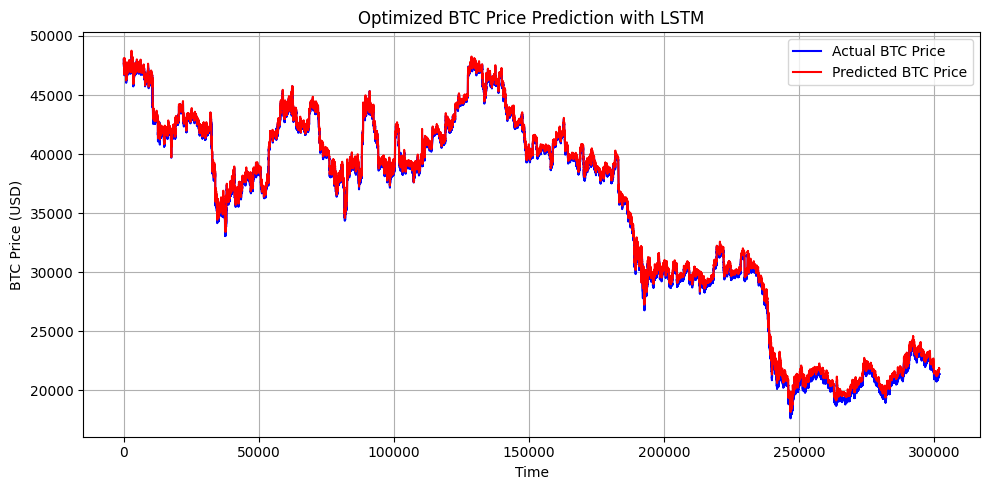

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("CryptoPrediction").getOrCreate()

# Load the dataset (update the path if needed)
file_path = "binance_multicoin_dataset.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Filter for BTC/USDT
btc_data = df.filter(df["symbol"] == "BTC/USDT").select(
    "date", "open", "high", "low", "close", "Volume BTC", "Volume USDT"
)

# Convert date column to timestamp and sort
btc_data = btc_data.withColumn("date", col("date").cast("timestamp"))
btc_pd = btc_data.toPandas()
btc_pd['date'] = pd.to_datetime(btc_pd['date'])
btc_pd = btc_pd.sort_values('date')
btc_pd.set_index('date', inplace=True)

# Normalize the 'close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
btc_pd['scaled_close'] = scaler.fit_transform(btc_pd['close'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 60
data = btc_pd['scaled_close'].values
X, y = create_sequences(data)

# Reshape for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model with Dropout and EarlyStopping
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted BTC price
plt.figure(figsize=(10, 5))
plt.plot(y_test, color='blue', label='Actual BTC Price')
plt.plot(predictions, color='red', label='Predicted BTC Price')
plt.title('Optimized BTC Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
